In [107]:
import numpy as np
import pandas as pd
import mygene
import omnipath as op
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import mellon as ml
from pyensembl import EnsemblRelease
import random
import netrd
import networkx as nx

In [108]:
# import gtex expression data

gtex_link = 'raw_data/GTEx_tissue_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz'
exp = pd.read_csv(gtex_link, sep='\t', index_col='Description', skiprows=2)

exp_cns = exp.loc[:, ['Brain - Amygdala',
       'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra']]
exp_cns = exp_cns.loc[(exp_cns > 0).any(axis=1)]

# import omnipath db
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]

In [109]:
reference = pd.read_csv('processed_data/hot-encoded-diseases_0.400000.csv', index_col=0)
disease_list = list(reference.columns)
iter=10
count = 0
all_LR_intersects = pd.DataFrame(np.zeros(shape=(iter, pow(len(disease_list), 2))))
all_LRI_intersects = pd.DataFrame(np.zeros(shape=(iter, pow(len(disease_list), 2))))
all_distances = pd.DataFrame(np.zeros(shape=(iter, pow(len(disease_list), 2))))

for disease1 in disease_list:
    for disease2 in disease_list:
            all_LR_intersects.rename(columns = {count : disease1+'/'+disease2}, inplace = True)
            all_LRI_intersects.rename(columns = {count : disease1+'/'+disease2}, inplace = True)
            all_distances.rename(columns = {count : disease1+'/'+disease2}, inplace = True)
            if (disease2+'/'+disease1) in all_distances.columns:
                all_LR_intersects[disease1+'/'+disease2] = all_LR_intersects[disease2+'/'+disease1]
                all_LRI_intersects[disease1+'/'+disease2] = all_LRI_intersects[disease2+'/'+disease1]
                all_distances[disease1+'/'+disease2] = all_distances[disease2+'/'+disease1]
            else:
                for i in range(0,iter):
                    # Create random list comparable to each disease
                    rand_disease1 = random.sample(list(range(0,len(exp_cns.index))), int(reference[disease1].sum()))
                    rand_disease2 = random.sample(list(range(0,len(exp_cns.index))), int(reference[disease2].sum()))
                    genes_disease1 = pd.DataFrame(exp_cns.index).iloc[rand_disease1]
                    genes_disease2 = pd.DataFrame(exp_cns.index).iloc[rand_disease2]

                    ### How many overlapping LRs do random disease 1 and random disease 2 share?
                    # Keep only genes with known LR role
                    genes_disease1 = list(genes_disease1[genes_disease1.isin(list(db['genesymbol_intercell_source'])) | genes_disease1.isin(list(db['genesymbol_intercell_target']))].dropna()['Description'])
                    genes_disease2 = list(genes_disease2[genes_disease2.isin(list(db['genesymbol_intercell_source'])) | genes_disease2.isin(list(db['genesymbol_intercell_target']))].dropna()['Description'])

                    # Check intersect of lists, add total number to all_intersects list
                    LR_intersect = len(list(set(genes_disease1) & set(genes_disease2)))
                    all_LR_intersects.iloc[i, count] = LR_intersect
                    
                    ### How many LRIs do random disease 1 and random disease 2 share?
                    # Get all LRIs where at least one is linked to diseases 
                    LRs_disease1 = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(genes_disease1))) | (db['genesymbol_intercell_target'].isin(list(genes_disease1)))]
                    LRs_disease2 = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(genes_disease2))) | (db['genesymbol_intercell_target'].isin(list(genes_disease2)))]
                    LRs_disease1 = LRs_disease1.dropna()
                    LRs_disease2 = LRs_disease2.dropna()
                    LRs_disease1_list = list(LRs_disease1['genesymbol_intercell_source']+LRs_disease1['genesymbol_intercell_target'])
                    LRs_disease2_list = list(LRs_disease2['genesymbol_intercell_source']+LRs_disease2['genesymbol_intercell_target'])
                    
                    # Check intersect of lists
                    LRI_intersect = len(list(set(LRs_disease1_list) & set(LRs_disease2_list)))
                    all_LRI_intersects.iloc[i, count] = LRI_intersect

                    ### How close are the random LR networks?
                    # Build an adjacency matrix per disease
                    unique_LRs_disease1 = pd.DataFrame(pd.concat([LRs_disease1['genesymbol_intercell_source'],LRs_disease1['genesymbol_intercell_target']], axis = 0).unique())
                    unique_LRs_disease2 = pd.DataFrame(pd.concat([LRs_disease2['genesymbol_intercell_source'],LRs_disease2['genesymbol_intercell_target']], axis = 0).unique())
                    both_unique = pd.concat([unique_LRs_disease1, unique_LRs_disease2], axis = 0)[0].unique()
                    # For deltacon comparison, the axes of the adjacency matrix must be the same
                    adj_LRs_disease1 = pd.DataFrame(np.zeros(shape=(len(both_unique), len(both_unique))), index = both_unique, columns = both_unique)
                    adj_LRs_disease2 = pd.DataFrame(np.zeros(shape=(len(both_unique), len(both_unique))), index = both_unique, columns = both_unique)
                    for n in range (0, np.shape(LRs_disease1)[0]):
                        adj_LRs_disease1.iloc[adj_LRs_disease1.index.get_loc(LRs_disease1.iloc[n]['genesymbol_intercell_source']), adj_LRs_disease1.columns.get_loc(LRs_disease1.iloc[n]['genesymbol_intercell_target'])] += 1
                    for n in range (0, np.shape(LRs_disease2)[0]):
                        adj_LRs_disease2.iloc[adj_LRs_disease2.index.get_loc(LRs_disease2.iloc[n]['genesymbol_intercell_source']), adj_LRs_disease2.columns.get_loc(LRs_disease2.iloc[n]['genesymbol_intercell_target'])] += 1
                    if (len(LRs_disease1)<1) or (len(LRs_disease2)<1):
                        all_distances.iloc[i, count] = 99
                    else:
                        # Create network and detect communities
                        G1 = nx.from_pandas_adjacency(adj_LRs_disease1)
                        G2 = nx.from_pandas_adjacency(adj_LRs_disease2)
                        # Calculate network distance
                        delta = netrd.distance.DeltaCon()
                        distance = delta.dist(G1, G2)

                        all_distances.iloc[i, count] = distance
            count+=1 

all_LR_intersects.to_csv('processed_data/02a_bootstrapped_disease_comparisons/bootstrapped_LRs_disease_comparisons.csv')
all_LRI_intersects.to_csv('processed_data/02a_bootstrapped_disease_comparisons/bootstrapped_LRIs_disease_comparisons.csv')
all_distances.to_csv('processed_data/02a_bootstrapped_disease_comparisons/bootstrapped_distances_disease_comparisons.csv')


In [110]:
reference = pd.read_csv('processed_data/hot-encoded-diseases_0.400000.csv', index_col=0)
disease_list = list(reference.columns)
iter=1
count = 0
real_LR_intersects = pd.DataFrame(np.zeros(shape=(iter, pow(len(disease_list), 2))))
real_LRI_intersects = pd.DataFrame(np.zeros(shape=(iter, pow(len(disease_list), 2))))
real_distances = pd.DataFrame(np.zeros(shape=(iter, pow(len(disease_list), 2))))

for disease1 in disease_list:
    for disease2 in disease_list:
            real_LR_intersects.rename(columns = {count : disease1+'/'+disease2}, inplace = True)
            real_LRI_intersects.rename(columns = {count : disease1+'/'+disease2}, inplace = True)
            real_distances.rename(columns = {count : disease1+'/'+disease2}, inplace = True)
            for i in range(0,iter):
                # Create random list comparable to each disease
                genes_disease1 = pd.DataFrame(reference[reference[disease1]==1].index)
                genes_disease2 = pd.DataFrame(reference[reference[disease2]==1].index)

                ### How many overlapping LRs do random disease 1 and random disease 2 share?
                # Keep only genes with known LR role
                genes_disease1 = list(genes_disease1[genes_disease1.isin(list(db['genesymbol_intercell_source'])) | genes_disease1.isin(list(db['genesymbol_intercell_target']))].dropna()['genes'])
                genes_disease2 = list(genes_disease2[genes_disease2.isin(list(db['genesymbol_intercell_source'])) | genes_disease2.isin(list(db['genesymbol_intercell_target']))].dropna()['genes'])

                # Check intersect of lists, add total number to all_intersects list
                LR_intersect = len(list(set(genes_disease1) & set(genes_disease2)))
                real_LR_intersects.iloc[i, count] = LR_intersect
                
                ### How many LRIs do random disease 1 and random disease 2 share?
                # Get all LRIs where at least one is linked to diseases 
                LRs_disease1 = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(genes_disease1))) | (db['genesymbol_intercell_target'].isin(list(genes_disease1)))]
                LRs_disease2 = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(genes_disease2))) | (db['genesymbol_intercell_target'].isin(list(genes_disease2)))]
                LRs_disease1 = LRs_disease1.dropna()
                LRs_disease2 = LRs_disease2.dropna()
                LRs_disease1_list = list(LRs_disease1['genesymbol_intercell_source']+LRs_disease1['genesymbol_intercell_target'])
                LRs_disease2_list = list(LRs_disease2['genesymbol_intercell_source']+LRs_disease2['genesymbol_intercell_target'])
                
                # Check intersect of lists
                LRI_intersect = len(list(set(LRs_disease1_list) & set(LRs_disease2_list)))
                real_LRI_intersects.iloc[i, count] = LRI_intersect

                ### How close are the random LR networks?
                # Build an adjacency matrix per disease
                unique_LRs_disease1 = pd.DataFrame(pd.concat([LRs_disease1['genesymbol_intercell_source'],LRs_disease1['genesymbol_intercell_target']], axis = 0).unique())
                unique_LRs_disease2 = pd.DataFrame(pd.concat([LRs_disease2['genesymbol_intercell_source'],LRs_disease2['genesymbol_intercell_target']], axis = 0).unique())
                both_unique = pd.concat([unique_LRs_disease1, unique_LRs_disease2], axis = 0)[0].unique()
                # For deltacon comparison, the axes of the adjacency matrix must be the same
                adj_LRs_disease1 = pd.DataFrame(np.zeros(shape=(len(both_unique), len(both_unique))), index = both_unique, columns = both_unique)
                adj_LRs_disease2 = pd.DataFrame(np.zeros(shape=(len(both_unique), len(both_unique))), index = both_unique, columns = both_unique)
                for n in range (0, np.shape(LRs_disease1)[0]):
                    adj_LRs_disease1.iloc[adj_LRs_disease1.index.get_loc(LRs_disease1.iloc[n]['genesymbol_intercell_source']), adj_LRs_disease1.columns.get_loc(LRs_disease1.iloc[n]['genesymbol_intercell_target'])] += 1
                for n in range (0, np.shape(LRs_disease2)[0]):
                    adj_LRs_disease2.iloc[adj_LRs_disease2.index.get_loc(LRs_disease2.iloc[n]['genesymbol_intercell_source']), adj_LRs_disease2.columns.get_loc(LRs_disease2.iloc[n]['genesymbol_intercell_target'])] += 1
                if (len(LRs_disease1)<1) or (len(LRs_disease2)<1):
                    real_distances.iloc[i, count] = 99
                else:
                    # Create network and detect communities
                    G1 = nx.from_pandas_adjacency(adj_LRs_disease1)
                    G2 = nx.from_pandas_adjacency(adj_LRs_disease2)
                    # Calculate network distance
                    delta = netrd.distance.DeltaCon()
                    distance = delta.dist(G1, G2)

                    real_distances.iloc[i, count] = distance
            count+=1 

In [111]:
pvals_LR = []
pvals_LRI = []
pvals_dist = []
for pair in list(all_distances.columns):
    pvals_LR.append((all_LR_intersects[pair]>real_LR_intersects[pair][0]).sum()/1000)
    pvals_LRI.append((all_LRI_intersects[pair]>real_LRI_intersects[pair][0]).sum()/1000)
    pvals_dist.append((all_distances[pair]<real_distances[pair][0]).sum()/1000)

pd.DataFrame(np.asarray(pvals_LR).reshape(18,18), columns = disease_list, index = disease_list).to_csv('processed_data/02a_bootstrapped_disease_comparisons/pvals_overlapping_LRs.csv')
pd.DataFrame(np.asarray(pvals_LRI).reshape(18,18), columns = disease_list, index = disease_list).to_csv('processed_data/02a_bootstrapped_disease_comparisons/pvals_overlapping_LRIs.csv')
pd.DataFrame(np.asarray(pvals_dist).reshape(18,18), columns = disease_list, index = disease_list).to_csv('processed_data/02a_bootstrapped_disease_comparisons/pvals_deltacon_distances.csv')

PermissionError: [Errno 13] Permission denied: 'processed_data/02a_bootstrapped_disease_comparisons/pvals_overlapping_LRIs.csv'

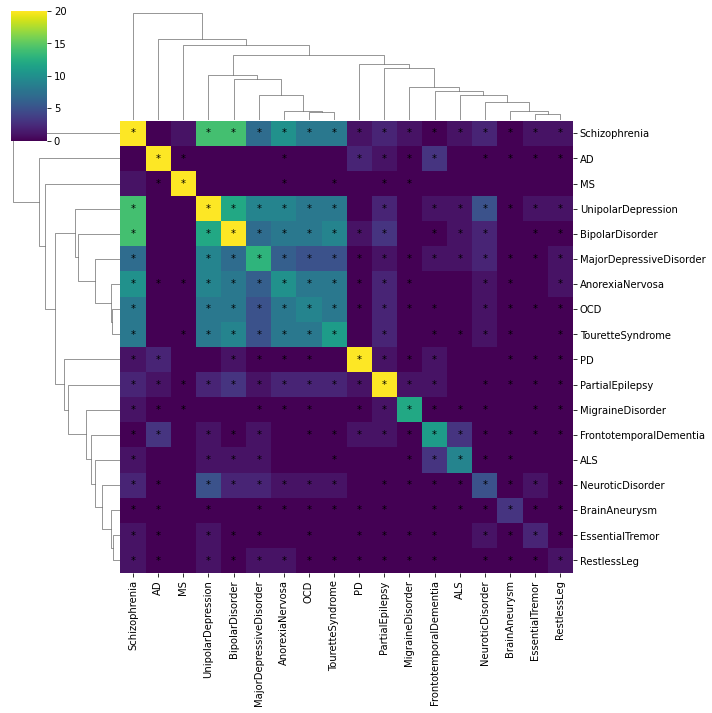

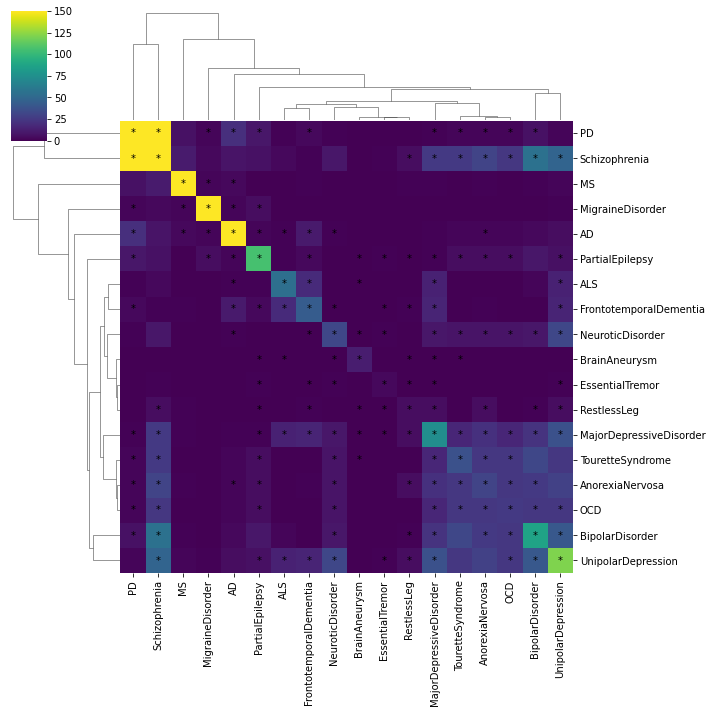

c:\Users\melis\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


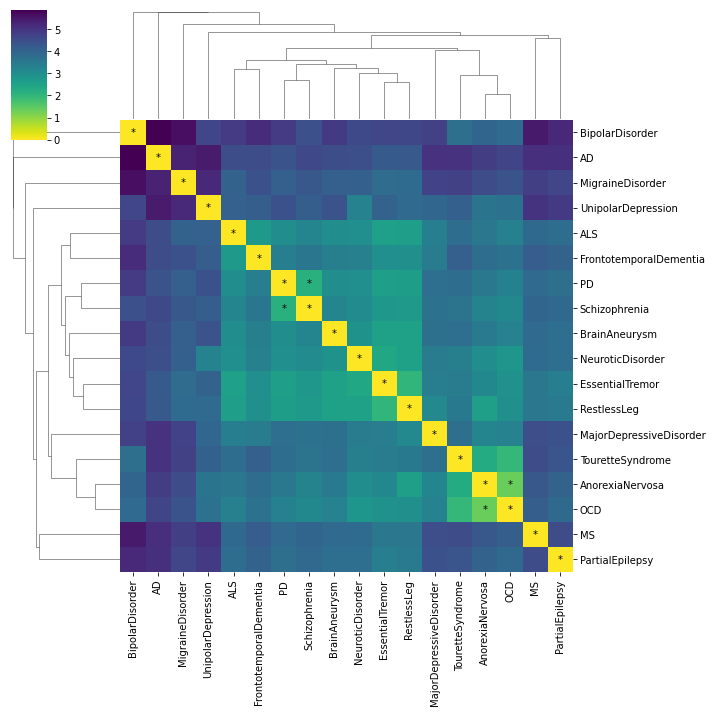

In [ ]:
# Visualise overlapping LRs
g = sns.clustermap(pd.DataFrame(np.asarray(real_LR_intersects).reshape(18,18), columns = disease_list, index = disease_list), vmax = 20, cmap = 'viridis')
mask = pd.DataFrame(np.asarray(pvals_LR).reshape(18,18), columns = disease_list, index = disease_list) < 0.05
# Get the order of the rows and columns from the clustermap
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Reorder the mask according to the clustermap
mask = mask.iloc[row_order, col_order]

# Iterate over the data and add a marker for significant p-values
for text in g.ax_heatmap.texts:
    text.set_visible(False)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask.iloc[i, j]:
            g.ax_heatmap.text(j+0.5, i+0.5, '*', ha='center', va='center', color='black')
plt.show()

# Visualise overlapping LRIs
g = sns.clustermap(pd.DataFrame(np.asarray(real_LRI_intersects).reshape(18,18), columns = disease_list, index = disease_list), vmax = 150, cmap = 'viridis')
mask = pd.DataFrame(np.asarray(pvals_LRI).reshape(18,18), columns = disease_list, index = disease_list) < 0.05
# Get the order of the rows and columns from the clustermap
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Reorder the mask according to the clustermap
mask = mask.iloc[row_order, col_order]

# Iterate over the data and add a marker for significant p-values
for text in g.ax_heatmap.texts:
    text.set_visible(False)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask.iloc[i, j]:
            g.ax_heatmap.text(j+0.5, i+0.5, '*', ha='center', va='center', color='black')
plt.show()

# Visualise Deltacon distances
g = sns.clustermap(pd.DataFrame(np.asarray(real_distances).reshape(18,18), columns = disease_list, index = disease_list), cmap = 'viridis_r')
mask = pd.DataFrame(np.asarray(pvals_dist).reshape(18,18), columns = disease_list, index = disease_list) < 0.05
# Get the order of the rows and columns from the clustermap
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Reorder the mask according to the clustermap
mask = mask.iloc[row_order, col_order]

# Iterate over the data and add a marker for significant p-values
for text in g.ax_heatmap.texts:
    text.set_visible(False)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask.iloc[i, j]:
            g.ax_heatmap.text(j+0.5, i+0.5, '*', ha='center', va='center', color='black')
plt.show()